In [1]:
%load_ext autoreload
%autoreload 2

import constants_and_utils as cu
from vaccine_intent import *
from graph_methods import *

import csv
import matplotlib.pyplot as plt
import os
from scipy import sparse
from scipy.stats import pearsonr, linregress
import pickle
import geopandas as gpd

/home/t-sechang/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Overview
This notebook estimates vaccine intent rates per ZCTA, county, and state, and analyzes the estimates.
1. Preprocessing: calculate Bing coverage per region and find active users with vaccine intent,
2. Compare vaccine intent estimates to CDC vaccination rates,
3. Analyze regional and demographic trends in vaccine intent estimates.

# Preprocessing

## Get summaries of Bing usage per state/county/zip and per user

In [ ]:
# load active Bing users per month
# compute num active users per state, county, and zip
# compute summary df for user (query count and max zip per month)
level2counts = {'Zip': None, 'County': None, 'State': None}
summary_df = None
for date_range in cu.DATE_RANGES[2:]:
    month = date_range.split('-')[1]
    print(date_range, month)
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'us_ds_%s.tsv' % date_range)
    bing_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded Bing user df, len =', len(bing_df))   
    
    # update counts per state, county, and zip
    for level in level2counts:
        mode_prop = bing_df['Max%sCount' % level] / bing_df['QueryCountWith%s' % level]
        kept_bing_df = bing_df[(bing_df['QueryCountWith%s' % level] >= 10) & (mode_prop >= 0.25)]
        print('Can assign %d (%.2f%%) active users to %s' % (len(kept_bing_df), 
                        100. * len(kept_bing_df) / len(bing_df), level))
        counts = kept_bing_df.groupby('Max%s' % level).size().rename('Count_%s' % month)
        if level2counts[level] is None:
            level2counts[level] = counts 
        else:
            level2counts[level] = pd.merge(level2counts[level], counts, left_index=True, right_index=True, how='outer')
        print('Added count info for %d unique %ss' % (len(counts), level))
    
    # update user counts     
    max_zips = bing_df.MaxZip.values
    mode_prop = bing_df['MaxZipCount'] / bing_df['QueryCountWithZip']
    keep_zip = (bing_df['QueryCountWithZip'] >= 10) & (mode_prop >= 0.25)
    max_zips[~(keep_zip.values)] = np.nan  # remove Zip when we can't assign confidently
    zip_bing_df = bing_df[['ClientId', 'QueryCount']].rename(columns={'QueryCount': 'QueryCount_%s' % month})
    zip_bing_df['MaxZip_%s' % month] = max_zips
    zip_bing_df = zip_bing_df.set_index('ClientId')
    if summary_df is None:
        summary_df = zip_bing_df
    else:
        summary_df = pd.merge(summary_df, zip_bing_df, left_index=True, right_index=True, how='outer')
    print()

In [ ]:
# save output
for level in level2counts:
    counts = level2counts[level]
    print(level, len(counts))
    counts.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'active_user_counts_%s.csv' % level))  # need to save index
    
print(len(summary_df))
summary_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'active_user_summary_02_to_08.csv'))
print('Saved complete summary')

qc_means = summary_df[qc_cols].mean(axis=1)
summary_df_small = pd.DataFrame({'NumMonthsActive': total_has_qc,
                                 'AvgQueryCount': qc_means})
summary_df_small.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'active_user_summary_small_02_to_08.csv'))
print('Saved small summary')

## Get vaccine intent t0s

In [ ]:
# load vaccine intent and active Bing users per month
# for each month, merge Bing user info with vaccine intent
all_dfs = []
level2counts = {'Zip': None, 'County': None, 'State': None}
amt_pos_urls, gnn_pos_urls = load_positive_urls()
for date_range in cu.DATE_RANGES[2:]:
    month = date_range.split('-')[1]
    print(date_range, month)
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'vaccine_intent_queries_%s.tsv' % date_range)
    query_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded vaccine intent queries, len =', len(query_df))
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'vaccine_intent_clicks_%s.tsv' % date_range)
    click_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded vaccine intent clicks, len =', len(click_df))
    in_amt = click_df.ClickUrl.isin(amt_pos_urls)
    in_gnn = click_df.ClickUrl.isin(gnn_pos_urls)
    matches_regex = click_df.ClickUrl.apply(is_vaccine_intent_url)
    label_source = np.zeros(len(click_df)) * np.nan
    label_source[matches_regex] = 0
    label_source[in_amt] = 1  # overrides regex
    label_source[in_gnn] = 2  # overrides regex
    click_df['UrlLabelSource'] = label_source
    missing_source = click_df.UrlLabelSource.isnull()
    if missing_source.sum() > 0:
        print('Warning: %d URLs missing label source' % missing_source.sum())
    # combine queries and clicks - we can still distinguish them with missing cols
    vaccine_df = pd.concat([query_df, click_df])  
    
    fn = os.path.join(cu.PATH_TO_BING_DATA, 'us_ds_%s.tsv' % date_range)
    bing_df = pd.read_csv(fn, delimiter='\t', header=0, quoting=csv.QUOTE_NONE, on_bad_lines='skip')
    print('Loaded Bing user df, len =', len(bing_df))   
    merged_df = vaccine_df.merge(bing_df, on='ClientId', how='left')
    matched = (~merged_df.QueryCount.isnull()).sum()
    print('Found active ClientId for %d (%.2f%%) vaccine intent queries' % (matched, 100. * matched / len(vaccine_df)))
    merged_df['datetime'] = merged_df.Request_RequestTime.apply(cu.extract_datetime)  # get day
    merged_df = merged_df.sort_values('datetime')  # sort by date so we can take earliest date as t0
    all_dfs.append(merged_df)
all_dfs = pd.concat(all_dfs)
print(len(all_dfs))

In [ ]:
# get first vaccine intent per user
user_df = all_dfs.drop_duplicates(subset=['ClientId'], keep='first')  # keep first vaccine intent per user
num_users = len(user_df)
user_df = user_df[~user_df.QueryCount.isnull()]  # drop users who weren't active in the month of first intent
print('Active users:', len(user_df), len(user_df) / num_users)

num_queries = only_queries.groupby('ClientId').size().rename('num_queries')  # num vaccine intent queries
user_df = user_df.merge(num_queries, how='left', left_on='ClientId', right_index=True)
num_clicks = all_dfs[all_dfs.ClickCount.isnull()].groupby('ClientId').size().rename('num_clicks')  # num vaccine intent clicks
user_df = user_df.merge(num_clicks, how='left', left_on='ClientId', right_index=True)
num_days = all_dfs.groupby('ClientId')['datetime'].nunique()  # num unique days of vaccine intent
user_df['num_days'] = num_days.loc[user_df.ClientId.values].values  # we can use loc since every user will appear in num_days
user_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_users_02_to_08.csv'), index=False)
user_df.head()

In [ ]:
# save what we would have if we only used queries
only_queries = all_dfs[all_dfs.ClickUrl.isnull()]
user_df = only_queries.drop_duplicates(subset=['ClientId'], keep='first')  # keep first vaccine intent per user
num_users = len(user_df)
user_df = user_df[~user_df.QueryCount.isnull()]  # drop users who weren't active in the month of first intent
print('Active users:', len(user_df), len(user_df) / num_users)
user_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_query_users_02_to_08.csv'), index=False)

In [ ]:
# save what we would have if we didn't have GNN expansion
is_gnn_click = all_dfs.UrlLabelSource == 2
without_gnn_clicks = all_dfs[~is_gnn_click]
user_df = without_gnn_clicks.drop_duplicates(subset=['ClientId'], keep='first')  # keep first vaccine intent per user
num_users = len(user_df)
user_df = user_df[~user_df.QueryCount.isnull()]  # drop users who weren't active in the month of first intent
print('Active users:', len(user_df), len(user_df) / num_users)
user_df.to_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_no_gnn_users_02_to_08.csv'), index=False)

## Get Bing counts and Census population, compute coverage

In [2]:
# get ZCTA demographics and county proportion voting Republican
zcta_df = get_zcta_df(include_lat_lon=True)
county_election_df = cu.get_county_election_df()
zcta_df = zcta_df.merge(county_election_df['prop_rep'], how='left', left_on='county', right_index=True)
zcta_df.head()

Loaded ZCTA to county mapping; found 33791 ZCTAs
Loaded zip code to ZCTA dataframe; found 41099 zip codes
Loaded ZCTA to state mapping; found 33139 ZCTAs
Finished loading all ZCTA data; found 33791 ZCTAs in total
SimpleMaps population vs ACS total_pop: N=32714, correlation = 1.000
SimpleMaps density vs ACS pop_per_sq_meter: N=32714, correlation = 1.000
Loaded county-level election data; found 3155 FIPS


/home/t-sechang/git_src/constants_and_utils.py:652: RuntimeWarning: invalid value encountered in divide
  zcta_df['percent_bachelor_or_higher'] = np.round(100. * zcta_df['num_25+_bachelor_or_higher'].values / zcta_df['num_25+'].values, 1)  # to match other percents


,county,county_name,land_area,state,median_income,total_pop,housing_units,percent_male,percent_female,percent_under_5,...,percent_20_to_34,percent_35_to_64,pop_per_sq_meter,num_25+,num_25+_bachelor_or_higher,percent_bachelor_or_higher,percent_without_bachelor,lat,lng,prop_rep
ZCTA,,,,,,,,,,,,,,,,,,,,,
601.0,72001,Adjuntas Municipio,166847909.0,PR,14398.0,16773.0,7282.0,49.6,50.4,4.3,...,18.8,39.3,0.000101,11886.0,1868.0,15.7,84.3,18.18027,-66.75266,NaN
602.0,72003,Aguada Municipio,78546713.0,PR,16771.0,37083.0,17510.0,48.9,51.1,3.7,...,19.0,41.6,0.000472,27192.0,5575.0,20.5,79.5,18.36075,-67.17541,NaN
603.0,72005,Aguadilla Municipio,88957333.0,PR,15786.0,45652.0,24453.0,48.6,51.4,4.1,...,18.4,38.1,0.000513,32901.0,7653.0,23.3,76.7,18.45744,-67.12225,NaN
606.0,72093,Maricao Municipio,114825382.0,PR,14980.0,6231.0,2789.0,49.4,50.6,3.9,...,17.5,41.3,0.000054,4569.0,482.0,10.5,89.5,18.16585,-66.93716,NaN
610.0,72011,Añasco Municipio,96129350.0,PR,20167.0,26502.0,12454.0,48.2,51.8,3.5,...,19.0,40.4,0.000276,19322.0,3292.0,17.0,83.0,18.29110,-67.12243,NaN


In [ ]:
# find ZCTAs with Bing user count and ACS pop count >= 50
# compute Bing coverage per ZCTA
zip2zcta = get_zip_to_zcta(return_dict=True)
kept_zcta_df = load_bing_coverage_per_zcta(zcta_df, zip2zcta=zip2zcta, min_pop_size=50)
kept_zcta_df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

In [4]:
# map state and county to list of ZCTAs
state2zctas = {}
county2zctas = {}
for z, row in kept_zcta_df.iterrows():
    s = row['state']
    state2zctas[s] = state2zctas.get(s, []) + [z]
    c = row['county']
    county2zctas[c] = county2zctas.get(c, []) + [z]
print('Found %d states and %d counties' % (len(state2zctas), len(county2zctas)))

Found 51 states and 3045 counties


In [5]:
# load county demographic data
county_demo_df = get_county_df()
print(len(county_demo_df))
county_demo_df.head()

Loaded county-level election data; found 3155 FIPS
3264


,total_pop,housing_units,percent_male,percent_female,percent_under_5,percent_5_to_9,percent_10_to_14,percent_15_to_19,percent_20_to_24,percent_25_to_34,...,percent_85_and_over,percent_under_18,percent_65_and_over,percent_white,percent_black,percent_american_indian,percent_asian,percent_hispanic,prop_dem,prop_rep
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,55639.0,23697.0,48.6,51.4,5.8,6.7,6.6,6.7,6.2,12.7,...,1.7,23.6,15.2,75.8,19.5,0.3,1.2,2.9,0.270184,0.714368
1003,218289.0,116747.0,48.5,51.5,5.5,5.3,6.9,6.0,5.1,11.2,...,1.9,21.5,20.5,85.4,8.8,0.7,0.9,4.6,0.224090,0.761714
1005,25026.0,12057.0,52.6,47.4,5.3,6.2,5.7,5.5,6.1,14.6,...,1.9,20.9,19.0,46.3,47.7,0.4,0.5,4.4,0.457882,0.534512
1007,22374.0,9237.0,53.7,46.3,5.6,5.3,5.4,6.5,5.8,14.5,...,1.5,20.5,16.5,76.6,22.5,0.1,0.3,2.7,0.206983,0.784263
1009,57755.0,24404.0,49.7,50.3,6.1,6.0,7.1,6.4,5.5,11.9,...,2.2,23.2,18.0,94.0,1.4,0.1,0.4,9.3,0.095694,0.895716


In [ ]:
# find counties with Bing user count and ACS pop count >= 50
# compute Bing coverage per county
county_bing_counts = pd.read_csv(os.path.join(cu.PATH_TO_PROCESSED_DATA, 'active_user_counts_County.csv')).set_index('MaxCounty')
county_counts = county_bing_counts.mean(axis=1)  # mean over months
kept_bing_counties = county_counts[county_counts >= 50].index
kept_acs_counties = county_demo_df[county_demo_df.total_pop >= 50].index
counties = sorted(set(kept_bing_counties).intersection(set(kept_acs_counties)))
print('%s counties have >= 50 Bing users, %s counties have >= 50 population count -> keeping %d' % (
        len(kept_bing_counties), len(kept_acs_counties), len(counties)))
kept_county_df = pd.DataFrame({'bing_count': county_counts.loc[counties], 
                             'pop_size': county_demo_df.loc[counties].total_pop})
coverage = kept_county_df.bing_count / kept_county_df.pop_size
kept_county_df['coverage'] = coverage
print('%.2f%% counties have coverage greater than 1' % (100 * (kept_county_df.coverage > 1).mean()))
kept_county_df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

# Compare vaccine intent to CDC

## Compute vaccine intent proportions

In [7]:
# load vaccine intent based on all clicks + queries
fn = os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_users_02_to_08.csv')
user_df = pd.read_csv(fn, low_memory=False)
user_df['datetime'] = pd.to_datetime(user_df.datetime)
print(len(user_df))

7447467


Can assign 7228613 (97.06%) of vaccine intent users to Zip


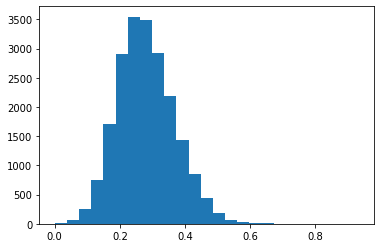

In [8]:
# get prop vaccine intent per ZCTA
merged_zcta_df = merge_user_df_and_zcta_df(user_df, kept_zcta_df, zip2zcta)
zcta_props = merged_zcta_df.prop_vaccine_intent
assert zcta_props.isna().sum() == 0
plt.hist(zcta_props, bins=25)
plt.show()

Can assign 7290960 (97.90%) of vaccine intent users to County


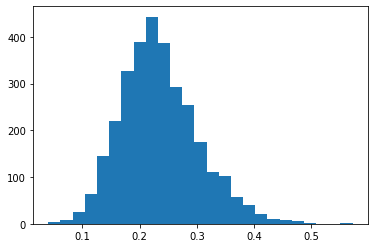

In [9]:
# get prop vaccine intent per county (direct estimate instead of weighted ZCTAs)
merged_county_df = merge_user_df_and_county_df(user_df, kept_county_df)
county_props = merged_county_df['prop_vaccine_intent']
assert county_props.isna().sum() == 0
plt.hist(county_props, bins=25)
plt.show()

## Make csv files for dashboard

In [10]:
# make state csv
prop_cols = ['prop_vaccine_intent', 'prop_vaccine_intent_lower', 'prop_vaccine_intent_upper']
state_df = pd.read_csv('../data/state_abbrs.csv')[['State', 'Code']]
state_df = state_df.rename(columns={'State': 'state', 'Code': 'abbr'}).set_index('abbr')
vis = [get_cumulative_prop_vaccine_intent_with_ci(state2zctas[s], merged_zcta_df) for s in state_df.index]
vi_df = pd.DataFrame(vis, columns=prop_cols, index=state_df.index)
state_df = state_df.merge(vi_df, how='inner', left_index=True, right_index=True)
state_df.round(2).to_csv(os.path.join(PATH_TO_RESULTS, 'state_data.csv'), index=True)
state_df.round(2)

,state,prop_vaccine_intent,prop_vaccine_intent_lower,prop_vaccine_intent_upper
abbr,,,,
AL,Alabama,0.25,0.25,0.26
AK,Alaska,0.22,0.22,0.23
AZ,Arizona,0.31,0.31,0.31
AR,Arkansas,0.22,0.21,0.22
CA,California,0.28,0.28,0.28
CO,Colorado,0.31,0.30,0.31
CT,Connecticut,0.40,0.40,0.40
DE,Delaware,0.36,0.36,0.36
DC,District of Columbia,0.31,0.30,0.31


In [11]:
# make county csv - include all counties, not only kept counties
vis = [get_cumulative_prop_vaccine_intent_with_ci(county2zctas[c], merged_zcta_df) 
       if c in county2zctas else np.nan for c in county_demo_df.index]
vi_df = pd.DataFrame(vis, columns=prop_cols, index=county_demo_df.index)
all_counties = pd.merge(county_demo_df['total_pop'], vi_df, how='inner', 
                        left_index=True, right_index=True)

has_vi = ~(all_counties.prop_vaccine_intent.isna())
print('Prop counties with vaccine intent: %.3f' % has_vi.mean())
print('Prop population with county vaccine intent: %.3f' % (
    (all_counties.total_pop * has_vi.astype(int)).sum() / all_counties.total_pop.sum()))
all_counties.round(2).to_csv(os.path.join(PATH_TO_RESULTS, 'county_data.csv'), index=True)
all_counties.round(2).sample(5)

Prop counties with vaccine intent: 0.933
Prop population with county vaccine intent: 0.988


,total_pop,prop_vaccine_intent,prop_vaccine_intent_lower,prop_vaccine_intent_upper
FIPS,,,,
19159,4922.0,0.21,0.11,0.31
1127,63802.0,0.23,0.21,0.25
17119,264403.0,0.30,0.29,0.30
37107,56350.0,0.22,0.20,0.24
48043,9231.0,0.15,0.12,0.18


In [12]:
# make ZCTA csv - include all ZCTAs, not only kept ZCTAs
all_zctas = zcta_df[['county', 'county_name', 'state', 'total_pop']].merge(
    merged_zcta_df[prop_cols], how='left', left_index=True, right_index=True)
has_vi = ~(all_zctas.prop_vaccine_intent.isna())
print('Prop ZCTAs with vaccine intent: %.3f' % has_vi.mean())
print('Prop population with ZCTA vaccine intent: %.3f' % (
    (all_zctas.total_pop * has_vi.astype(int)).sum() / all_zctas.total_pop.sum()))

# add county proportions
county_subdf = all_counties[prop_cols].rename(columns={c:f'county_{c}' for c in prop_cols})
all_zctas = all_zctas.merge(county_subdf, how='left', left_on='county', right_index=True)
has_vi = ~(all_zctas.county_prop_vaccine_intent.isna())
print('Prop ZCTAs with county vaccine intent: %.3f' % has_vi.mean())
print('Prop population with county vaccine intent: %.3f' % (
    (all_zctas.total_pop * has_vi.astype(int)).sum() / all_zctas.total_pop.sum()))

all_zctas.round(2).to_csv(os.path.join(PATH_TO_RESULTS, 'zcta_data.csv'), index=True)
all_zctas.round(2).sample(5)

Prop ZCTAs with vaccine intent: 0.618
Prop population with ZCTA vaccine intent: 0.966
Prop ZCTAs with county vaccine intent: 0.986
Prop population with county vaccine intent: 0.990


,county,county_name,state,total_pop,prop_vaccine_intent,prop_vaccine_intent_lower,prop_vaccine_intent_upper,county_prop_vaccine_intent,county_prop_vaccine_intent_lower,county_prop_vaccine_intent_upper
ZCTA,,,,,,,,,,
30066.0,13067,Cobb County,GA,57953.0,0.31,0.30,0.32,0.29,0.29,0.29
35776.0,1071,Jackson County,AL,3596.0,0.21,0.14,0.29,0.20,0.18,0.21
25969.0,54089,Summers County,WV,1013.0,NaN,NaN,NaN,0.23,0.18,0.29
96142.0,6017,El Dorado County,CA,934.0,NaN,NaN,NaN,0.31,0.30,0.31
35216.0,1073,Jefferson County,AL,37828.0,0.29,0.27,0.30,0.29,0.28,0.29


## State-level + cumulative

In [17]:
from analyze_cdc_records import *

# load CDC state-level vaccination rates
states = pd.read_csv('../data/state_abbrs.csv')
abbr2state = dict(zip(states.Code, states.State))
state2abbr = dict(zip(states.State, states.Code))
cdc_state_df = load_vaccine_state_data()
cdc_state_df.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,...,Additional_Doses_Unk_Manuf,Second_Booster,Second_Booster_50Plus,Second_Booster_50Plus_Vax_Pct,Second_Booster_65Plus,Second_Booster_65Plus_Vax_Pct,Second_Booster_Janssen,Second_Booster_Moderna,Second_Booster_Pfizer,Second_Booster_Unk_Manuf
0,2022-06-16,24,AZ,15453620.0,611400.0,5898020.0,8944200.0,0.0,212312.0,225636.0,...,2493.0,NaN,326891.0,26.3,237317.0,32.4,516.0,151843.0,191708.0,873.0
1,2022-06-16,24,GU,326460.0,24100.0,87780.0,214580.0,0.0,193757.0,213706.0,...,4.0,NaN,7599.0,23.8,4156.0,32.6,5.0,3308.0,4609.0,0.0
2,2022-06-16,24,AR,6461880.0,256200.0,2718520.0,3487160.0,0.0,214125.0,228388.0,...,526.0,NaN,98072.0,21.3,74091.0,26.5,72.0,53595.0,47887.0,81.0
3,2022-06-16,24,NM,4663645.0,188300.0,1821100.0,2654245.0,0.0,222414.0,236033.0,...,322.0,NaN,143495.0,31.6,99272.0,39.3,233.0,69714.0,80352.0,125.0
4,2022-06-16,24,MP,127430.0,3600.0,25720.0,98110.0,0.0,245762.0,264916.0,...,0.0,NaN,682.0,7.1,295.0,12.3,1.0,113.0,700.0,0.0


WITHOUT WEIGHTING BY COVERAGE
CDC proportions missing for 0 regions
Keeping 51 regions
Avg ratio of vaccine intent / CDC rate: 0.044
Correlation: r=0.793 (0.661, 0.877)
Linear regression: slope=0.061, intercept=-0.008

WITH WEIGHTING BY COVERAGE
CDC proportions missing for 0 regions
Keeping 51 regions
Avg ratio of vaccine intent / CDC rate: 0.563
Correlation: r=0.861 (0.768, 0.919)
Linear regression: slope=0.583, intercept=-0.010


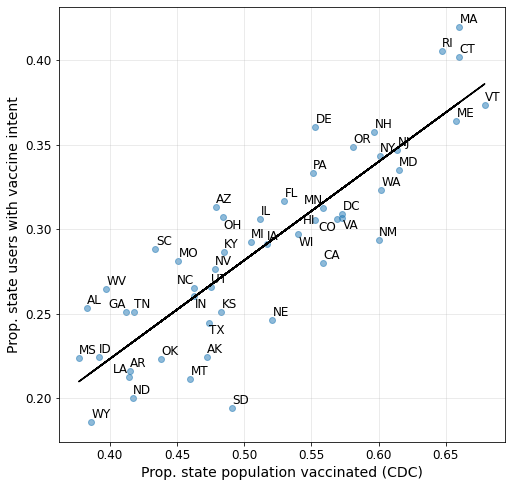

In [18]:
# state-level cumulative
print('WITHOUT WEIGHTING BY COVERAGE')
_ = compare_cdc_and_vaccine_intent_props(cdc_state_df, region2zctas=state2zctas, merged_zcta_df=merged_zcta_df, 
                                         weight_by_coverage=False, make_plot=False, mode='state')
print('\nWITH WEIGHTING BY COVERAGE')
kept_states, x, y = compare_cdc_and_vaccine_intent_props(cdc_state_df, region2zctas=state2zctas, merged_zcta_df=merged_zcta_df, 
                                         weight_by_coverage=True, make_plot=True, mode='state')
# check that results match what we saved for dashboard
expected_vi = state_df.loc[kept_states].prop_vaccine_intent
assert np.isclose(expected_vi, y).all()
plt.savefig(os.path.join(PATH_TO_RESULTS, 'cdc_vs_vaccine_intent_cumulative_state.pdf'), bbox_inches='tight')

/tmp/ipykernel_1246576/108142786.py:3: DtypeWarning: Columns (11,20) have mixed types. Specify dtype option on import or set low_memory=False.
  no_gnn_user_df = pd.read_csv(fn)


4953458
Can assign 4817816 (97.26%) of vaccine intent users to Zip
CDC proportions missing for 0 regions
Keeping 51 regions
Avg ratio of vaccine intent / CDC rate: 0.366
Correlation: r=0.797 (0.668, 0.879)
Linear regression: slope=0.503, intercept=-0.069


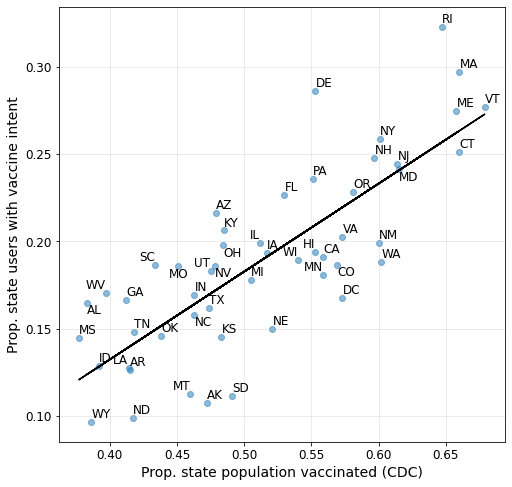

In [18]:
# try with all clicks + queries minus GNN clicks
fn = os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_no_gnn_users_02_to_08.csv')
no_gnn_user_df = pd.read_csv(fn)
print(len(no_gnn_user_df))
no_gnn_user_df['datetime'] = pd.to_datetime(no_gnn_user_df.datetime)

no_gnn_merged_zcta_df = merge_user_df_and_zcta_df(no_gnn_user_df, kept_zcta_df, zip2zcta)
out = compare_cdc_and_vaccine_intent_props(cdc_state_df, region2zctas=state2zctas,
                                           merged_zcta_df=no_gnn_merged_zcta_df, 
                                           weight_by_coverage=True, make_plot=True, mode='state')

/tmp/ipykernel_1510209/2739394287.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  query_user_df = pd.read_csv(fn)


3183082
Can assign 3089726 (97.07%) of vaccine intent users to Zip
CDC proportions missing for 0 regions
Keeping 51 regions
Avg ratio of vaccine intent / CDC rate: 0.219
Correlation: r=0.622 (0.418, 0.766)
Linear regression: slope=0.279, intercept=-0.030


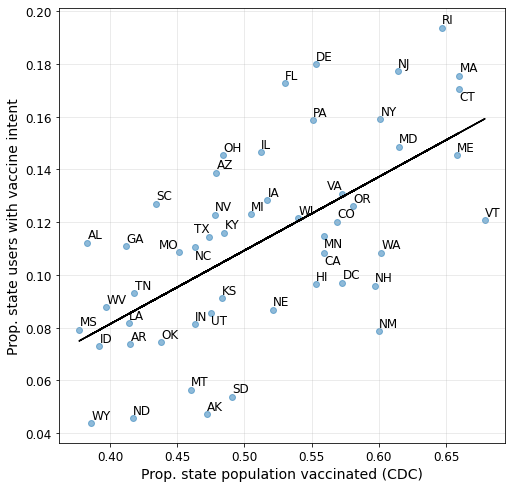

In [21]:
# try with only queries
fn = os.path.join(cu.PATH_TO_PROCESSED_DATA, 'vaccine_intent_query_users_02_to_08.csv')
query_user_df = pd.read_csv(fn)
print(len(query_user_df))
query_user_df['datetime'] = pd.to_datetime(query_user_df.datetime)

query_merged_zcta_df = merge_user_df_and_zcta_df(query_user_df, kept_zcta_df, zip2zcta)
out = compare_cdc_and_vaccine_intent_props(cdc_state_df, region2zctas=state2zctas,
                                           merged_zcta_df=query_merged_zcta_df, 
                                           weight_by_coverage=True, make_plot=True, mode='state')

## State-level time series 

In [19]:
# add ZCTA to user_df
mode_prop = user_df['MaxZipCount'] / user_df['QueryCountWithZip']
level_bools = (user_df['QueryCountWithZip'] >= 10) & (mode_prop >= 0.25)
print('Can assign %d (%.2f%%) of vaccine intent users to Zip' % 
      (level_bools.sum(), 100. * level_bools.sum() / len(user_df)))
zip_user_df = user_df[level_bools].copy()
zip_user_df['ZCTA_from_zip'] = np.array([zip2zcta.get(z, np.nan) for z in zip_user_df.MaxZip])

Can assign 7228613 (97.06%) of vaccine intent users to Zip


In [20]:
# get all daily curves for vaccine intent and CDC 
ts = time.time()
# a little before April for smoothing
datetimes = cu.get_datetimes_in_range(datetime.datetime(2021, 3, 20), datetime.datetime(2021, 8, 31))
vi_vecs = []
cdc_vecs = []
state_abbrs = states.Code
for abbr in state_abbrs:
    zctas = state2zctas[abbr]
    state_vi = get_daily_vaccine_intent_over_time(zctas, datetimes, zip_user_df, merged_zcta_df)
    state_cdc = get_daily_first_dose_over_time(cdc_state_df, abbr, datetimes)
    vi_vecs.append(state_vi)
    cdc_vecs.append(state_cdc)
print('Finished computing all vecs [time=%.2fs]' % (time.time()-ts))
with open(os.path.join(PATH_TO_RESULTS, 'daily_state_vecs_vaccine_intent_vs_cdc.pkl'), 'wb') as f:
    pickle.dump((datetimes, state_abbrs, vi_vecs, cdc_vecs), f)

Finished computing all vecs [time=27.75s]


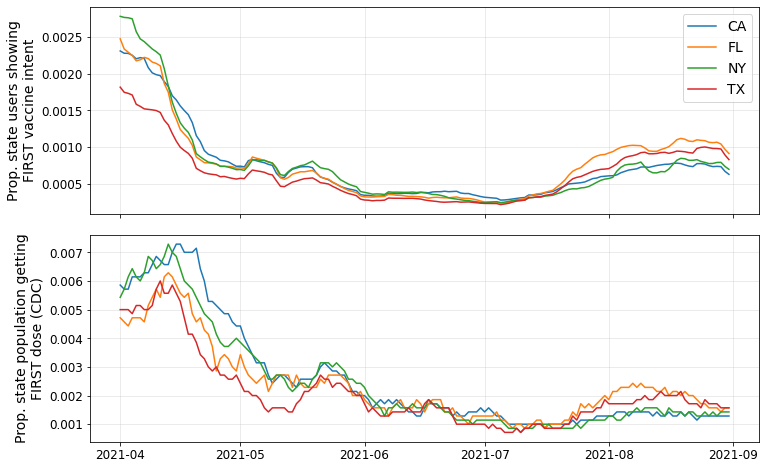

In [21]:
# compute optimal lags for all states
# plot time series for 4 largest states
lags = np.arange(0, 22, 1)
lag2corrs = {l:[] for l in lags}
with open(os.path.join(PATH_TO_RESULTS, 'daily_state_vecs_vaccine_intent_vs_cdc.pkl'), 'rb') as f:
    datetimes, state_abbrs, vi_vecs, cdc_vecs = pickle.load(f)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.subplots_adjust(hspace=0.1)

for state, vi, cdc in zip(state_abbrs, vi_vecs, cdc_vecs): 
    vi = cu.smooth_new_counts(vi)
    cdc = cu.smooth_new_counts(np.clip(cdc, 0, None))  # should not be negative
    to_keep = datetimes >= datetime.datetime(2021, 4, 1)
    vi = vi[to_keep]
    cdc = cdc[to_keep]
    
    if state in ['CA', 'FL', 'NY', 'TX']:
        axes[0].plot_date(datetimes[to_keep], vi, fmt='-', marker=None, label=state)
        axes[1].plot_date(datetimes[to_keep], cdc, fmt='-', marker=None)
    for lag in lags:
        if lag > 0:  # eg, CDC is 7 days behind vaccine intent
            lagged_vaccine_intent_vec = vi[:-lag]
            lagged_cdc_vec = cdc[lag:]
        elif lag < 0:  # eg, CDC is 7 days ahead of vaccine intent
            lagged_vaccine_intent_vec = vi[-lag:]
            lagged_cdc_vec = cdc[:lag]
        else:
            lagged_vaccine_intent_vec = vi
            lagged_cdc_vec = cdc
        isnan = np.isnan(lagged_vaccine_intent_vec) | np.isnan(lagged_cdc_vec)
        r, p = pearsonr(lagged_vaccine_intent_vec[~isnan], lagged_cdc_vec[~isnan])
        lag2corrs[lag].append(r)

axes[0].legend(fontsize=14)
axes[0].set_ylabel('Prop. state users showing\nFIRST vaccine intent', fontsize=14)
axes[1].set_ylabel('Prop. state population getting\nFIRST dose (CDC)', fontsize=14)
for ax in axes:
    ax.tick_params(which='both', labelsize=12)
    ax.grid(alpha=0.3)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'vaccine_intent_vs_first_dose_over_time_top_states.pdf'), bbox_inches='tight')

In [22]:
# median correlation per lag
corr_df = pd.DataFrame(lag2corrs)
corr_df['state'] = state_abbrs
corr_df = corr_df.set_index('state')
corr_df.median()[lags].round(4)

0     0.7804
1     0.7949
2     0.8127
3     0.8369
4     0.8517
5     0.8644
6     0.8705
7     0.8851
8     0.8897
9     0.8895
10    0.8836
11    0.8805
12    0.8799
13    0.8731
14    0.8678
15    0.8625
16    0.8522
17    0.8461
18    0.8387
19    0.8295
20    0.8158
21    0.8066
dtype: float64

In [23]:
# correlation when no lag is allowed
no_lag = corr_df[0]
print('no lag: mean = %.3f, median = %.3f, std = %.3f, 50 CI = %.3f-%.3f, 90 CI = %.3f-%.3f' % (
    no_lag.mean(), no_lag.median(), no_lag.std(), no_lag.quantile(.25), no_lag.quantile(.75),
    no_lag.quantile(0.05), no_lag.quantile(0.95)))

no lag: mean = 0.753, median = 0.780, std = 0.118, 50 CI = 0.730-0.832, 90 CI = 0.483-0.874


In [24]:
# summarize lags and correlations
best_corrs = []
for state, row in corr_df.iterrows():
    idx = np.argmax(row[lags].values)
    best_corrs.append({'state': state, 'lag': lags[idx], 'corr': row[lags].values[idx]})
best_corrs = pd.DataFrame(best_corrs, columns=['state', 'lag', 'corr']).set_index('state')
print('Num states above 0.7:', (best_corrs['corr'] > 0.7).sum())
best_corrs.describe(percentiles=[0.025, 0.05, 0.25, 0.75, 0.95, 0.975]).round(2)

Num states above 0.7: 48


,lag,corr
count,51.00,51.00
mean,10.88,0.87
std,5.11,0.11
min,0.00,0.37
2.5%,4.00,0.57
5%,4.00,0.72
25%,7.50,0.86
50%,10.00,0.91
75%,14.50,0.94
95%,21.00,0.96


California
Texas
Florida
New York
Pennsylvania
Illinois
Ohio
Georgia
North Carolina
Michigan
New Jersey
Virginia
Washington
Arizona
Tennessee


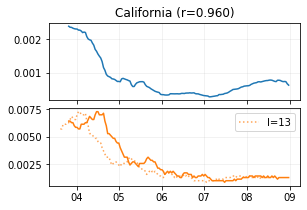

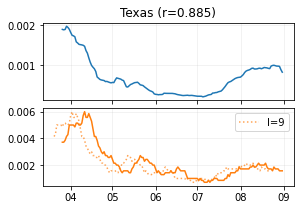

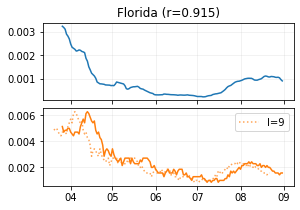

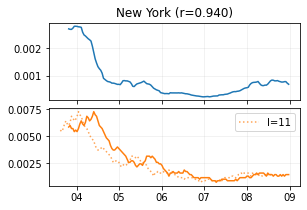

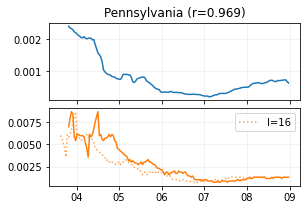

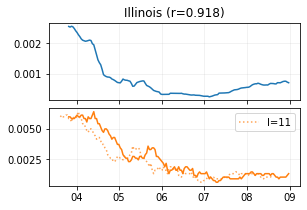

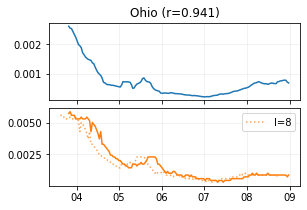

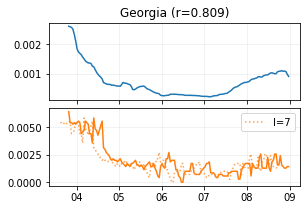

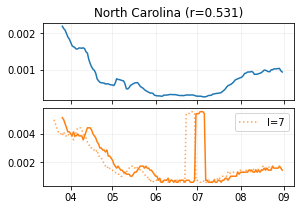

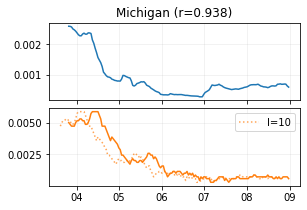

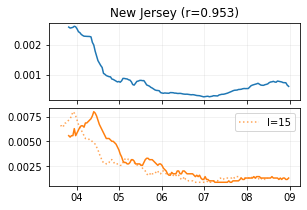

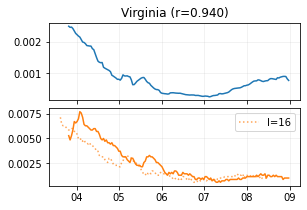

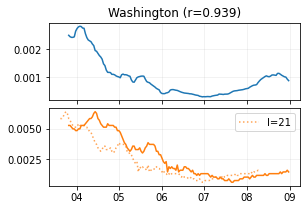

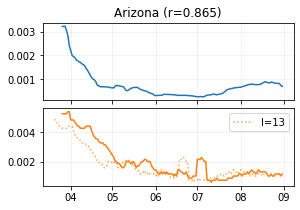

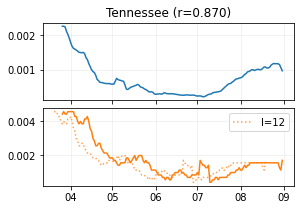

In [25]:
# plot time series for 15 largest states
states = pd.read_csv('../data/state_abbrs.csv')
abbr2state = dict(zip(states.Code, states.State))
state2vi = dict(zip(state_abbrs, vi_vecs))
state2cdc = dict(zip(state_abbrs, cdc_vecs))
largest_states = ['CA', 'TX', 'FL', 'NY', 'PA', 
                  'IL', 'OH', 'GA', 'NC', 'MI',
                  'NJ', 'VA', 'WA', 'AZ', 'TN']
for state in largest_states: 
    print(abbr2state[state])
    vi = cu.smooth_new_counts(state2vi[state])
    cdc = cu.smooth_new_counts(np.clip(state2cdc[state], 0, None))  # should not be negative
    fig, axes = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True)
    fig.subplots_adjust(hspace=0.1)
    axes[0].plot_date(datetimes, vi, fmt='-', marker=None, color='tab:blue')
    axes[0].grid(alpha=0.2)
    axes[1].plot_date(datetimes, cdc, fmt='-', marker=None, color='tab:orange')
    axes[1].grid(alpha=0.2)
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    
    row = corr_df.loc[state]
    idx = np.argmax(row[lags].values)
    best_lag = lags[idx]
    axes[0].set_title('%s (r=%.3f)' % (abbr2state[state], row[lags].values[idx]))
    if best_lag > 0:
        axes[1].plot_date(datetimes[:-best_lag], cdc[best_lag:], fmt=':', alpha=0.7,
                      marker=None, color='tab:orange', label='l=%d' % best_lag)
    else:
        axes[1].plot_date(datetimes, cdc, fmt=':', alpha=0.7,
                      marker=None, color='tab:orange', label='l=%d' % best_lag)
    axes[1].legend()
    plt.savefig(os.path.join(PATH_TO_RESULTS, '%s_vi_cdc_over_time.pdf' % state), bbox_inches='tight')

## County-level + cumulative

In [26]:
from analyze_cdc_records import *

# load CDC vaccination rates
states = pd.read_csv('../data/state_abbrs.csv')
abbr2state = dict(zip(states.Code, states.State))
state2abbr = dict(zip(states.State, states.Code))
cdc_county_df = load_vaccine_county_data()
cdc_county_df.head()

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Booster_Doses_Vax_Pct_UR_Equity,Booster_Doses_12PlusVax_Pct_UR_Equity,Booster_Doses_18PlusVax_Pct_UR_Equity,Booster_Doses_65PlusVax_Pct_UR_Equity,Census2019,Census2019_5PlusPop,Census2019_5to17Pop,Census2019_12PlusPop,Census2019_18PlusPop,Census2019_65PlusPop
0,2022-06-13,19175.0,24,Union County,IA,97.4,6799.0,55.5,6799.0,58.6,...,8.0,8.0,8.0,8.0,12241.0,11599.0,2085.0,10542.0,9514.0,2573.0
1,2022-06-13,16043.0,24,Fremont County,ID,97.8,6968.0,53.2,6964.0,56.8,...,6.0,6.0,6.0,6.0,13099.0,12268.0,2399.0,11119.0,9869.0,2286.0
2,2022-06-13,17029.0,24,Coles County,IL,98.3,25501.0,50.4,25491.0,52.9,...,8.0,8.0,8.0,7.0,50621.0,48177.0,6613.0,44662.0,41564.0,8848.0
3,2022-06-13,17163.0,24,St. Clair County,IL,98.3,186838.0,71.9,186675.0,76.7,...,3.0,3.0,3.0,3.0,259686.0,243453.0,44316.0,219779.0,199137.0,42597.0
4,2022-06-13,17171.0,24,Scott County,IL,98.3,2212.0,44.7,2212.0,47.0,...,8.0,8.0,8.0,7.0,4951.0,4705.0,797.0,4302.0,3908.0,972.0


In [27]:
# check completeness percentage of counties
sub_cdc_county_df = cdc_county_df[cdc_county_df.Date == '2021-08-31']
to_keep = sub_cdc_county_df.Completeness_pct >= 80 # keep counties with at least 80% complete
print(len(sub_cdc_county_df), np.sum(to_keep))
kept_states = set(sub_cdc_county_df[to_keep].Recip_State.unique())
print(len(kept_states))
for state, abbr in state2abbr.items():
    if abbr not in kept_states:
        # this should be a subset of the states mentioned in 
        # https://www.kff.org/coronavirus-covid-19/issue-brief/vaccination-is-local-covid-19-vaccination-rates-vary-by-county-and-key-characteristics/
        print('missing', state, abbr) 

3224 2596
48
missing Georgia GA
missing Hawaii HI
missing Texas TX
missing Vermont VT
missing Virginia VA
missing West Virginia WV


WITHOUT WEIGHTING BY COVERAGE
CDC proportions missing for 9 regions
CDC completeness below 80% for 585 counties
Keeping 2455 regions
Avg ratio of vaccine intent / CDC rate: 0.039
Correlation: r=0.628 (0.603, 0.651)
Linear regression: slope=0.050, intercept=-0.003

WITH WEIGHTING BY COVERAGE
CDC proportions missing for 9 regions
CDC completeness below 80% for 585 counties
Keeping 2455 regions
Avg ratio of vaccine intent / CDC rate: 0.599
Correlation: r=0.677 (0.655, 0.698)
Linear regression: slope=0.413, intercept=0.084


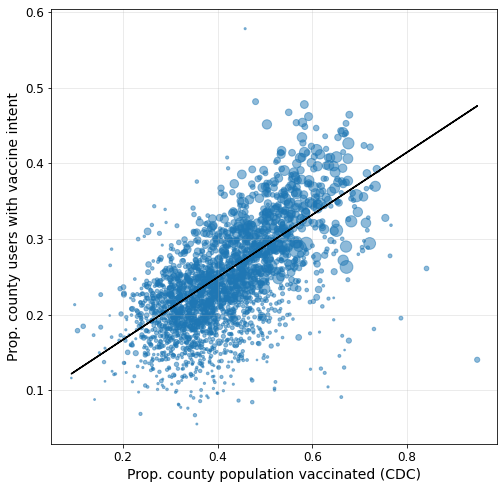

In [28]:
# county-level + cumulative 
region2weight = dict(zip(county_demo_df.index, np.sqrt(county_demo_df.total_pop)))
print('WITHOUT WEIGHTING BY COVERAGE')
_ = compare_cdc_and_vaccine_intent_props(cdc_county_df, region2zctas=county2zctas, merged_zcta_df=merged_zcta_df, 
                                         weight_by_coverage=False, make_plot=False, mode='county', region2weight=region2weight)
print('\nWITH WEIGHTING BY COVERAGE')
kept_counties, cdc_props, vi_props = compare_cdc_and_vaccine_intent_props(cdc_county_df, region2zctas=county2zctas, 
                                         merged_zcta_df=merged_zcta_df, weight_by_coverage=True,
                                         make_plot=True, mode='county', region2weight=region2weight)
# check that results match what we saved for dashboard
expected_vi = all_counties.loc[kept_counties].prop_vaccine_intent
assert np.isclose(expected_vi, vi_props).all()
plt.savefig(os.path.join(PATH_TO_RESULTS, 'cdc_vs_vaccine_intent_cumulative_county.pdf'), bbox_inches='tight')

CDC proportions missing for 7 regions
CDC completeness below 80% for 605 counties
Keeping 2478 regions
Avg ratio of vaccine intent / CDC rate: 0.596
Correlation: r=0.671 (0.649, 0.692)
Linear regression: slope=0.414, intercept=0.084


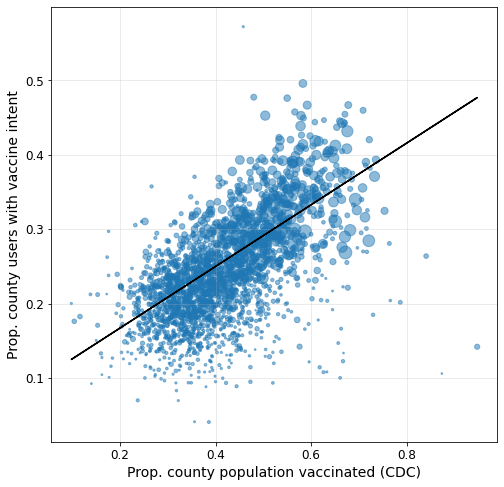

In [29]:
# try direct estimate per county (num vaccine intent / bing count)
# instead of weighted over ZCTAs
counties, cdc_props, vi_props = compare_cdc_and_vaccine_intent_props(cdc_county_df, vi_prop_df=merged_county_df,
                                         make_plot=True, mode='county', region2weight=region2weight)

In [30]:
# compare to alternatives with worse CDC reporting
# drop completeness filter
_ = compare_cdc_and_vaccine_intent_props(cdc_county_df, region2zctas=county2zctas, 
                                         merged_zcta_df=merged_zcta_df, weight_by_coverage=True,
                                         make_plot=False, mode='county', region2weight=region2weight,
                                         min_completeness=0)
# drop weighting by population size
_ = compare_cdc_and_vaccine_intent_props(cdc_county_df, region2zctas=county2zctas, 
                                         merged_zcta_df=merged_zcta_df, weight_by_coverage=True,
                                         make_plot=False, mode='county', region2weight=None)

CDC proportions missing for 9 regions
CDC completeness below 0% for 0 counties
Keeping 3036 regions
Avg ratio of vaccine intent / CDC rate: inf
Correlation: r=0.541 (0.515, 0.565)
Linear regression: slope=0.215, intercept=0.181


/home/t-sechang/git_src/vaccine_intent.py:449: RuntimeWarning: divide by zero encountered in divide
  ratio = y / x


CDC proportions missing for 9 regions
CDC completeness below 80% for 585 counties
Keeping 2455 regions
Avg ratio of vaccine intent / CDC rate: 0.599
Correlation: r=0.579 (0.552, 0.604)
Linear regression: slope=0.361, intercept=0.090


# Trends in vaccine intent estimates

## Visualize as maps

In [32]:
zcta_geom = load_zcta_shapefile()
zcta_geom = zcta_geom.merge(all_zctas.prop_vaccine_intent, how='left', left_index=True, right_index=True)
print(zcta_geom.prop_vaccine_intent.isna().mean())

Loaded ZCTA shapefile, found 33791 ZCTAs
0.3815217069633926


In [38]:
county_geom = load_county_shapefile().reset_index()
county_geom = county_geom.set_index(county_geom.GEOID.astype(float))
county_geom = county_geom.merge(all_counties.prop_vaccine_intent, how='left', left_index=True, right_index=True)
print(county_geom.prop_vaccine_intent.isna().mean())

Loaded county shapefile, found 3234 counties
0.05844155844155844


In [39]:
min_val = min(zcta_geom.prop_vaccine_intent.quantile(0.01),
              county_geom.prop_vaccine_intent.quantile(0.01))
max_val = max(zcta_geom.prop_vaccine_intent.quantile(0.99), 
              county_geom.prop_vaccine_intent.quantile(0.99))
print(min_val, max_val)

0.09803495311167945 0.5003277319953583


0.02895752895752896
0.3760249902381882
Loaded state shapefile, found 56 states and state-equivalents


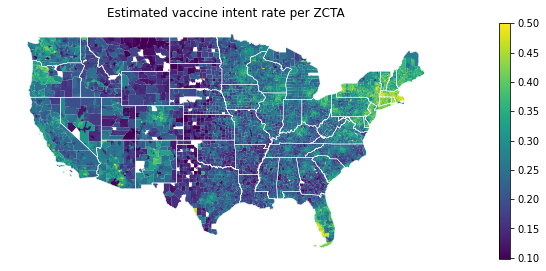

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Estimated vaccine intent rate per ZCTA', fontsize=12)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0)

# plot county-level first
to_plot = county_geom[(county_geom.INTPTLAT > 25) & (county_geom.INTPTLAT < 50)]
print(to_plot.prop_vaccine_intent.isna().mean())
to_plot.plot('prop_vaccine_intent', ax=ax, legend=True, cax=cax, vmin=min_val, vmax=max_val)

# overlay with ZCTA
to_plot = zcta_geom[(zcta_geom.INTPTLAT20 > 25) & (zcta_geom.INTPTLAT20 < 50)]
print(to_plot.prop_vaccine_intent.isna().mean())
to_plot.plot('prop_vaccine_intent', ax=ax, vmin=min_val, vmax=max_val)

# overlay with state boundaries
state_geom = load_state_shapefile()
to_plot = state_geom[(state_geom.INTPTLAT > 25) & (state_geom.INTPTLAT < 50)]
to_plot.boundary.plot(color='white', ax=ax, linewidth=0.5)  # plot state boundaries
ax.set_axis_off()
plt.savefig(os.path.join(PATH_TO_RESULTS, 'zcta_vaccine_intent_map.png'), dpi=500, bbox_inches='tight')

211
0.15639810426540285


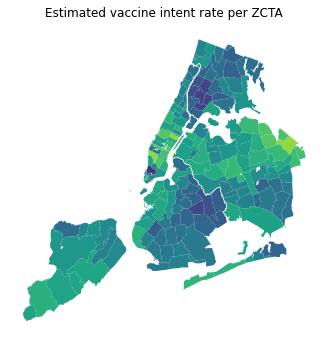

In [43]:
nyc_counties = [36005, # Bronx
                36061,  # Manhattan
                36047, # Brooklyn
                36085, # Staten Island
                36081]  # Queens
nyc_zctas = zcta_df[zcta_df.county.isin(nyc_counties)].index
print(len(nyc_zctas))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Estimated vaccine intent rate per ZCTA', fontsize=12)

# overlay with ZCTA
to_plot = zcta_geom.loc[nyc_zctas]
print(to_plot.prop_vaccine_intent.isna().mean())
to_plot.plot('prop_vaccine_intent', ax=ax, vmin=min_val, vmax=max_val)

# overlay with county boundaries
to_plot = county_geom.loc[nyc_counties]
to_plot.boundary.plot(color='white', ax=ax, linewidth=0.5)  # plot county boundaries
ax.set_axis_off()
plt.savefig(os.path.join(PATH_TO_RESULTS, 'nyc_zcta_vaccine_intent_map.pdf'), bbox_inches='tight')

## Demographic trends

In [44]:
# replace with log
zcta_df['pop_per_sq_meter'] = np.log(zcta_df.pop_per_sq_meter)  

/home/t-sechang/env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
# compute correlation results
zcta_cols = ['percent_bachelor_or_higher', 'median_income',
             'percent_65_and_over', 'percent_under_18',
             'percent_white', 'percent_asian', 'percent_black', 'percent_hispanic', 
             'percent_female', 'pop_per_sq_meter', 
             'prop_rep']
corr_df = compare_vaccine_intent_props_and_demographics(merged_zcta_df, zcta_df, zcta_cols, metric='corr',
                                                        verbose=False)
corr_df.round(3).sort_values('r', ascending=False)

,r,lower,upper
demo,,,
percent_bachelor_or_higher,0.529,0.519,0.539
median_income,0.489,0.479,0.500
pop_per_sq_meter,0.347,0.335,0.359
percent_65_and_over,0.187,0.174,0.200
percent_asian,0.184,0.171,0.197
percent_white,0.164,0.151,0.178
percent_female,0.106,0.092,0.119
percent_hispanic,-0.144,-0.158,-0.131
percent_black,-0.199,-0.212,-0.186


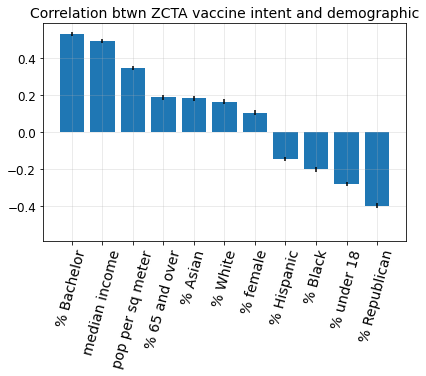

In [46]:
ax = plot_vaccine_intent_demographic_trends(corr_df, 'r', metric='corr', 
                                       ax=None, color='tab:blue')
ymin, ymax = ax.get_ylim()
max_abs = max(abs(ymin), ymax)
ax.set_ylim(-max_abs, max_abs)  # make symmetric
plt.savefig(os.path.join(PATH_TO_RESULTS, 'vaccine_intent_demographic_corrs.pdf'), bbox_inches='tight')

Found 1340 ZCTAs in CA
Found 1328 ZCTAs in TX
Found 896 ZCTAs in FL
Found 1173 ZCTAs in NY
Found 1086 ZCTAs in PA
Found 846 ZCTAs in IL
Found 820 ZCTAs in OH
Found 540 ZCTAs in GA
Found 640 ZCTAs in NC
Found 741 ZCTAs in MI


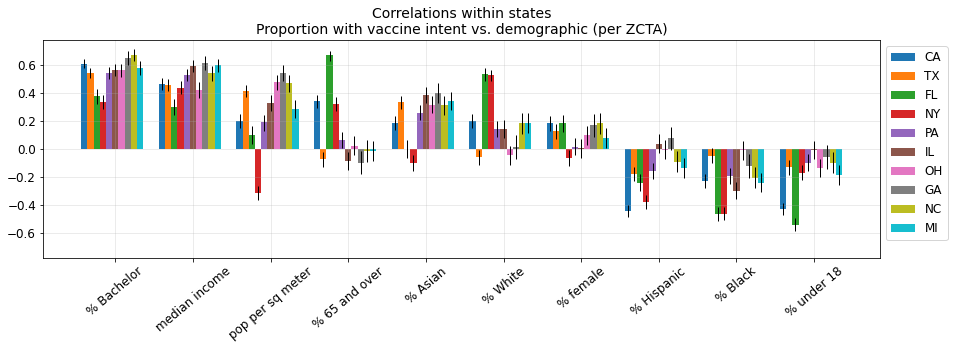

In [47]:
# correlations per state
state2results = {}
states = ['CA', 'TX', 'FL', 'NY', 'PA', 'IL', 'OH', 'GA', 'NC', 'MI'] # 10 largest states
order = list(corr_df.sort_values('r', ascending=False).index)
if 'prop_rep' in order:
    order.remove('prop_rep') # bc it's not ZCTA level and some states only have 50-60 counties

fig, ax = plt.subplots(figsize=(15, 4))
width = 0.4
spacing = len(states)*width + 1
x_pos = np.arange(0, spacing*len(order), spacing)
for state in states:
    state_merged_zcta_df = merged_zcta_df[merged_zcta_df.state == state]
    print('Found %d ZCTAs in %s' % (len(state_merged_zcta_df), state))
    results = compare_vaccine_intent_props_and_demographics(state_merged_zcta_df, zcta_df, 
                                                            order, metric='corr', verbose=False)
    y = results.r.values
    err = [y-results.lower.values, results.upper.values-y]
    ax.bar(x_pos, y, width=width, yerr=err, label=state, error_kw={'elinewidth': 1})
    x_pos += width
ax.legend(bbox_to_anchor=(1, 1), fontsize=12)
ax.set_title('Correlations within states\nProportion with vaccine intent vs. demographic (per ZCTA)', fontsize=14)
ax.set_xticks(np.arange(0, spacing*len(order), spacing) + width * (len(states)/2))
labels = [cu.get_print_name_for_col(c) for c in order]
ax.set_xticklabels(labels, rotation=40, fontsize=12)
ax.grid(alpha=0.3)
ax.tick_params(labelsize=12)
ymin, ymax = ax.get_ylim()
max_abs = max(abs(ymin), ymax)
ax.set_ylim(-max_abs, max_abs)  # make symmetric
plt.savefig(os.path.join(PATH_TO_RESULTS, 'state_vaccine_intent_demographic_correlations.pdf'), bbox_inches='tight')

In [41]:
# compute bootstrapped quartile measures
quartile_df = get_bootstrapped_demographic_trends(merged_zcta_df, zcta_df, zcta_cols, metric='quartile', 
                                    sample_zctas=True, sample_vi_rates=True, num_trials=1000)
quartile_df.to_csv(os.path.join(PATH_TO_RESULTS, 'bootstrapped_quartile_demo.csv'))
quartile_df[['point_est', 'lower', 'upper']].round(3).sort_values('point_est', ascending=False)

,point_est,lower,upper
demo,,,
pop_per_sq_meter,52.159,49.157,55.658
percent_bachelor_or_higher,48.395,46.326,50.351
median_income,39.084,37.385,40.798
percent_asian,30.750,28.890,32.665
percent_65_and_over,20.106,18.201,21.946
percent_female,9.548,7.779,11.410
percent_hispanic,7.551,5.400,9.721
percent_black,3.371,1.307,5.480
percent_white,-0.516,-2.440,1.454


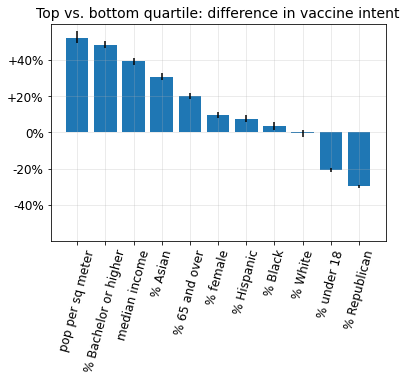

In [28]:
quartile_df = pd.read_csv(os.path.join(PATH_TO_RESULTS, 'bootstrapped_quartile_demo.csv')).set_index('demo')
ax = plot_vaccine_intent_demographic_trends(quartile_df, 'point_est', metric='quartile', 
                                       ax=None, color='tab:blue')
ymin, ymax = ax.get_ylim()
max_abs = max(abs(ymin), ymax)
ax.set_ylim(-max_abs, max_abs)  # make symmetric
yticks = np.arange(-40, 41, 20)
yticklabels = ['%d%%' % d if d <= 0 else '+%d%%' % d for d in yticks]
ax.set_yticks(yticks, labels=yticklabels)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'vaccine_intent_demographic_quartiles.pdf'), bbox_inches='tight')

top, N=3681, cumulative prop: 0.3311
bottom, N=5368, cumulative prop: 0.2757


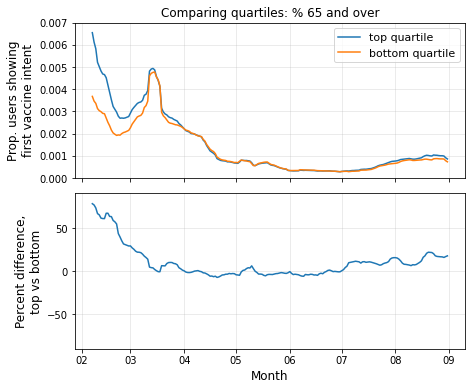

In [44]:
# age trends over time
datetimes = cu.get_datetimes_in_range(datetime.datetime(2021, 2, 1), datetime.datetime(2021, 8, 31))
col = 'percent_65_and_over'
results_df = get_quartile_vaccine_intent_over_time(merged_zcta_df, zcta_df, zip_user_df, col, datetimes,
                                                   verbose=True)
axes = plot_quartile_comparison_over_time(results_df, col, datetimes, axes=None)
axes[0].set_ylim(0, 0.007)
axes[1].set_ylim(-90, 90)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'quartiles_over_time_%s.pdf' % col), bbox_inches='tight')

top, N=3697, cumulative prop: 0.2190
bottom, N=6614, cumulative prop: 0.3121


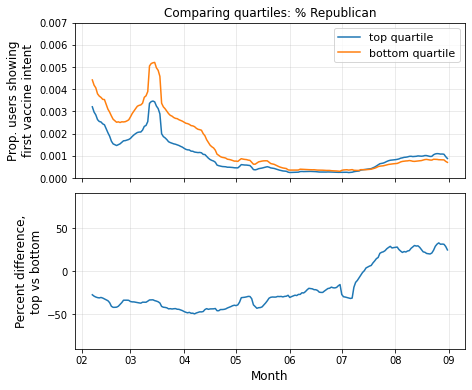

In [46]:
# political trends over time
col = 'prop_rep'
results_df = get_quartile_vaccine_intent_over_time(merged_zcta_df, zcta_df, zip_user_df, col, datetimes,
                                                   verbose=True)
axes = plot_quartile_comparison_over_time(results_df, col, datetimes, axes=None)
axes[0].set_ylim(0, 0.007)
axes[1].set_ylim(-90, 90)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'quartiles_over_time_%s.pdf' % col), bbox_inches='tight')